In [28]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import os
import string

In [29]:

# --- Setup Output Directory ---
script_dir = os.getcwd() 
OUTPUT_DIR = os.path.join(script_dir, "eda_results")
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
REPORT_FILE = os.path.join(OUTPUT_DIR, "eda_report.txt")

# Clear the report file if it exists
if os.path.exists(REPORT_FILE):
    os.remove(REPORT_FILE)

def write_to_report(content, title=""):
    """Appends content to the report file."""
    with open(REPORT_FILE, 'a', encoding='utf-8') as f:
        if title:
            f.write(f"--- {title} ---\n")
        f.write(str(content) + "\n\n")

# --- 1. Load the Data ---
def load_data(file_path):
    """Loads a JSON file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def load_entity_set(file_path):
    """Loads the entity set from a text file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        return [line.strip() for line in f]

# Define data paths (assuming a 'data' subfolder)
df_text = pd.DataFrame(load_data(os.path.join(script_dir, 'data', 'medxpertqa_text_test.json')))
df_mm = pd.DataFrame(load_data(os.path.join(script_dir, 'data', 'medxpertqa_mm_test.json')))

# You could combine them if desired, adding a 'type' column
df_text['type'] = 'text'
df_mm['type'] = 'multimodal'
df_all = pd.concat([df_text, df_mm], ignore_index=True)

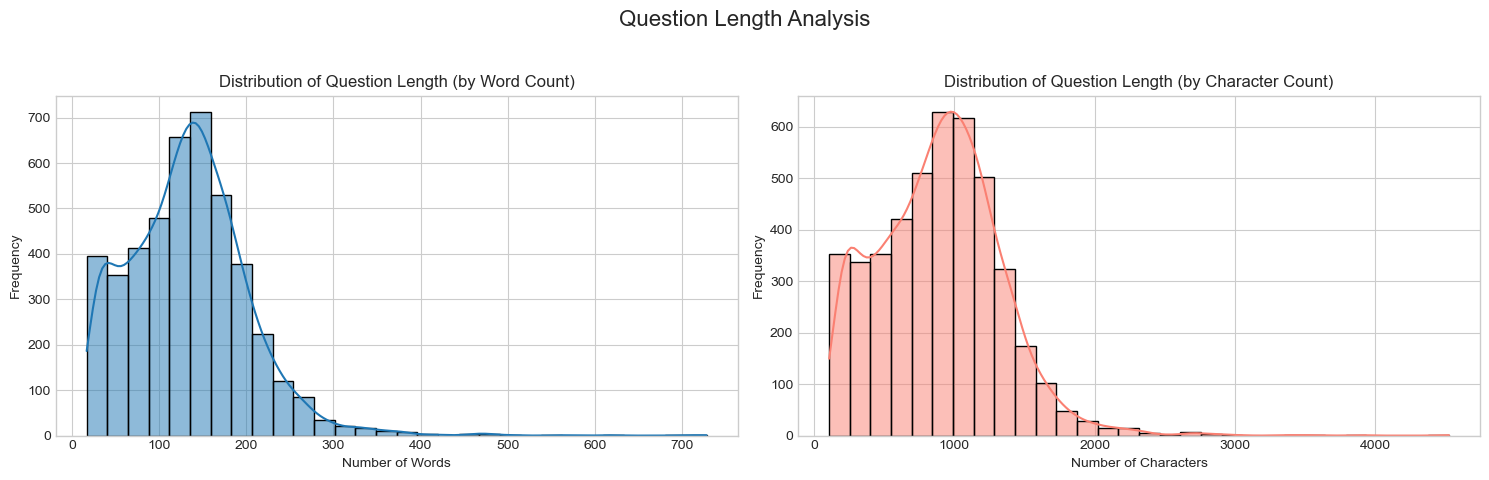

<Figure size 640x480 with 0 Axes>

In [ ]:
write_to_report("EDA Survey for MedXpertQA Dataset", title="START OF REPORT")

# --- 2. Basic Data and Sentence Analysis ---
report_title = "2. Basic Data and Sentence Analysis"
basic_stats = (
    f"Number of text samples: {len(df_text)}\n"
    f"Number of multimodal samples: {len(df_mm)}\n"
    f"Total number of samples: {len(df_all)}"
)
write_to_report(basic_stats, title=report_title)

df_all['question_word_count'] = df_all['question'].apply(lambda x: len(x.split()))
df_all['question_char_count'] = df_all['question'].apply(len)
write_to_report(df_all[['question_word_count', 'question_char_count']].describe(), title="Question Length Statistics")

# Plot and save sentence length distributions
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df_all['question_word_count'], bins=30, ax=axes[0], kde=True)
axes[0].set_title('Distribution of Question Length (by Word Count)')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')
sns.histplot(df_all['question_char_count'], bins=30, ax=axes[1], kde=True, color='salmon')
axes[1].set_title('Distribution of Question Length (by Character Count)')
axes[1].set_xlabel('Number of Characters')
axes[1].set_ylabel('Frequency')
plt.suptitle('Question Length Analysis', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

image_path = os.path.join(OUTPUT_DIR, "question_length_distributions.png")
plt.savefig(image_path)
write_to_report(f"Image saved to: {image_path}", title="Plot: Question Length Distributions")

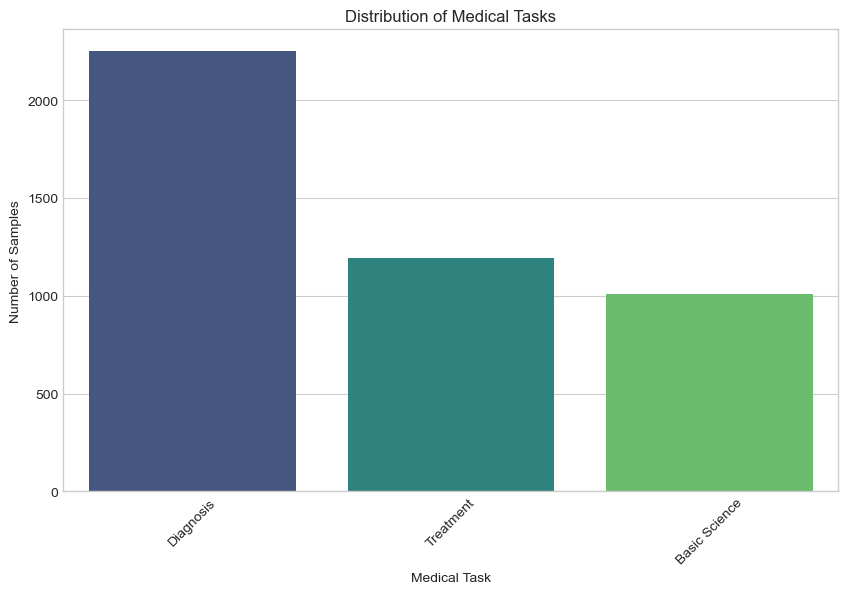

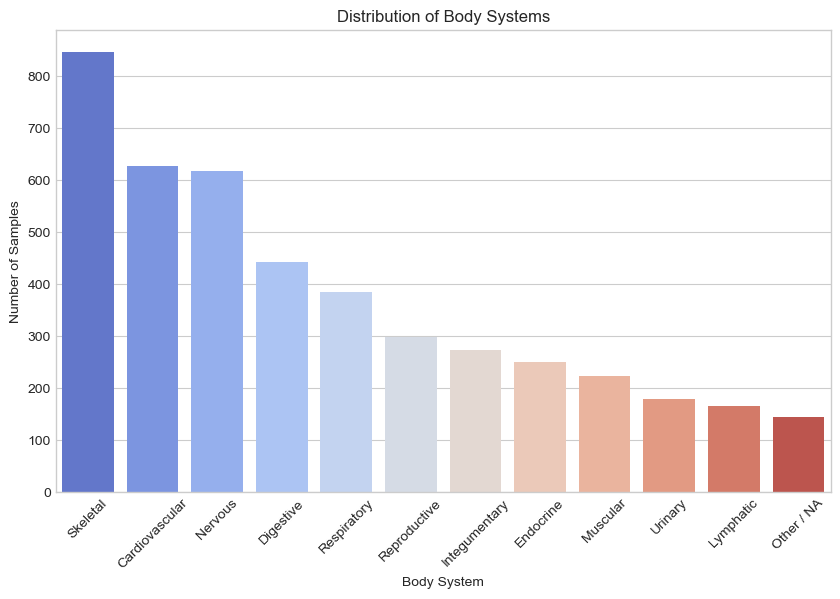

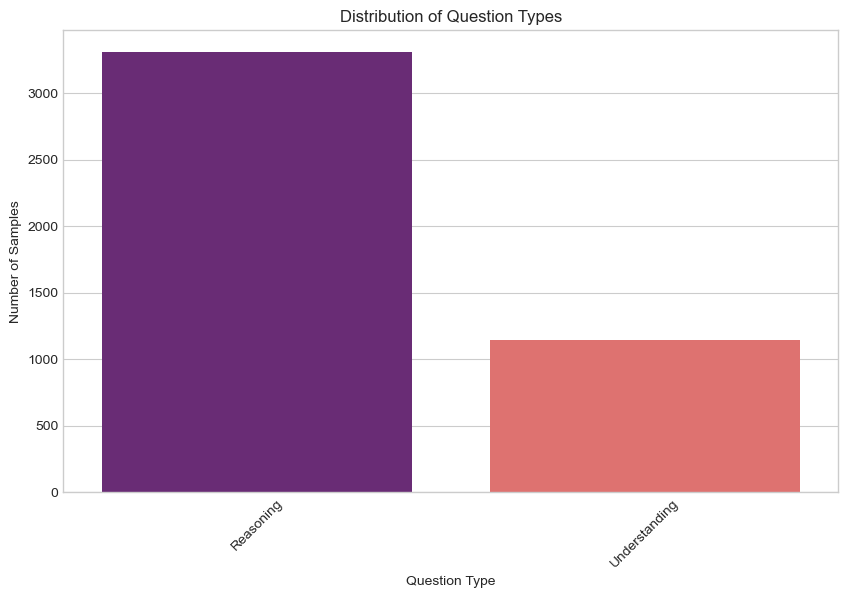

In [31]:
# --- 3. Categorical Label Analysis (`sent_label`) ---
report_title = "3. Categorical Label Analysis"
task_counts = df_all['medical_task'].value_counts()
system_counts = df_all['body_system'].value_counts()
type_counts = df_all['question_type'].value_counts()

write_to_report(task_counts.to_string(), title="Data Table: Medical Task Distribution")
write_to_report(system_counts.to_string(), title="Data Table: Body System Distribution")
write_to_report(type_counts.to_string(), title="Data Table: Question Type Distribution")

# Plot and save task distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=task_counts.index, y=task_counts.values, hue=task_counts.index, palette='viridis', legend=False)
plt.title('Distribution of Medical Tasks')
plt.xlabel('Medical Task')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
image_path_1 = os.path.join(OUTPUT_DIR, "medical_task_distribution.png")
plt.savefig(image_path_1)
write_to_report(f"Image saved to: {image_path_1}", title="Plot: Medical Task Distribution")
plt.show()

# Plot and save body system distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=system_counts.index, y=system_counts.values, hue=system_counts.index, palette='coolwarm', legend=False)
plt.title('Distribution of Body Systems')
plt.xlabel('Body System')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
image_path_2 = os.path.join(OUTPUT_DIR, "body_system_distribution.png")
plt.savefig(image_path_2)
write_to_report(f"Image saved to: {image_path_2}", title="Plot: Body System Distribution")
plt.show()

# Plot and save question type distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=type_counts.index, y=type_counts.values, hue=type_counts.index, palette='magma', legend=False)
plt.title('Distribution of Question Types')
plt.xlabel('Question Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
image_path_3 = os.path.join(OUTPUT_DIR, "question_type_distribution.png")
plt.savefig(image_path_3)
write_to_report(f"Image saved to: {image_path_3}", title="Plot: Question Type Distribution")
plt.show()

In [32]:
# Distribution of Correct Answer Labels
label_counts = df_all['label'].value_counts().sort_index()
write_to_report(label_counts, title="Distribution of Correct Answer Labels")

df_all['num_options'] = df_all['options'].apply(lambda x: len(x))
write_to_report(df_all['num_options'].describe(), title="Statistics for Number of Options per Question")

--- Analyzing Length of Correct vs. Incorrect Answer Options ---


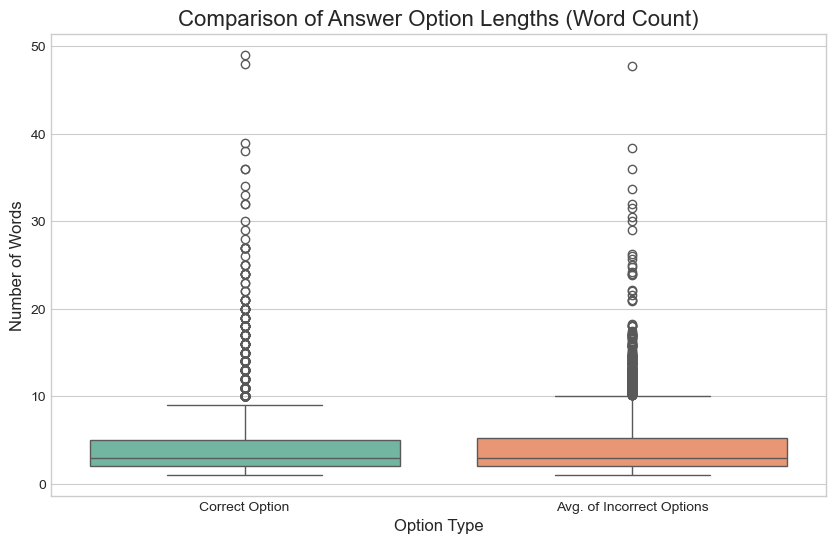


Statistical Summary of Option Lengths:
       correct_option_len  avg_incorrect_option_len
count         4450.000000               4450.000000
mean             4.164270                  4.169032
std              4.091363                  3.462229
min              1.000000                  1.000000
25%              2.000000                  2.000000
50%              3.000000                  3.000000
75%              5.000000                  5.222222
max             49.000000                 47.777778

--- Answer Option Analysis Complete ---


In [33]:
print("--- Analyzing Length of Correct vs. Incorrect Answer Options ---")

# --- Length Analysis of Options ---

# This function will process one row of the dataframe
def get_option_lengths(row):
    correct_label = row['label']
    options_dict = row['options']
    
    # Get the text of the correct answer
    correct_answer_text = options_dict[correct_label]
    
    # Calculate word count of the correct answer
    correct_length = len(correct_answer_text.split())
    
    # Calculate average word count of incorrect answers
    incorrect_lengths = []
    for label, text in options_dict.items():
        if label != correct_label:
            incorrect_lengths.append(len(text.split()))
            
    # If there are incorrect options, calculate their average length
    avg_incorrect_length = np.mean(incorrect_lengths) if incorrect_lengths else 0
    
    return pd.Series([correct_length, avg_incorrect_length], index=['correct_option_len', 'avg_incorrect_option_len'])

# Apply the function to the entire dataframe
option_lengths_df = df_all.apply(get_option_lengths, axis=1)

# Concatenate the new length columns with the original dataframe for more analysis
df_all_with_lengths = pd.concat([df_all, option_lengths_df], axis=1)


# --- Visualization ---

# Create a box plot to compare the distributions
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all_with_lengths[['correct_option_len', 'avg_incorrect_option_len']], palette="Set2")
plt.title('Comparison of Answer Option Lengths (Word Count)', fontsize=16)
plt.ylabel('Number of Words', fontsize=12)
plt.xlabel('Option Type', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Correct Option', 'Avg. of Incorrect Options'])
image_path = os.path.join(OUTPUT_DIR, "option_length_boxplot.png")
plt.savefig(image_path)
write_to_report(f"Image saved to: {image_path}", title="Plot: Option Length Comparison")
plt.show()

# --- Statistical Summary ---
print("\nStatistical Summary of Option Lengths:")
summary_stats_options = df_all_with_lengths[['correct_option_len', 'avg_incorrect_option_len']].describe()
print(summary_stats_options)

report_title_options = "Analysis of Correct vs. Incorrect Option Lengths"
write_to_report(summary_stats_options, title=report_title_options)

print("\n--- Answer Option Analysis Complete ---")

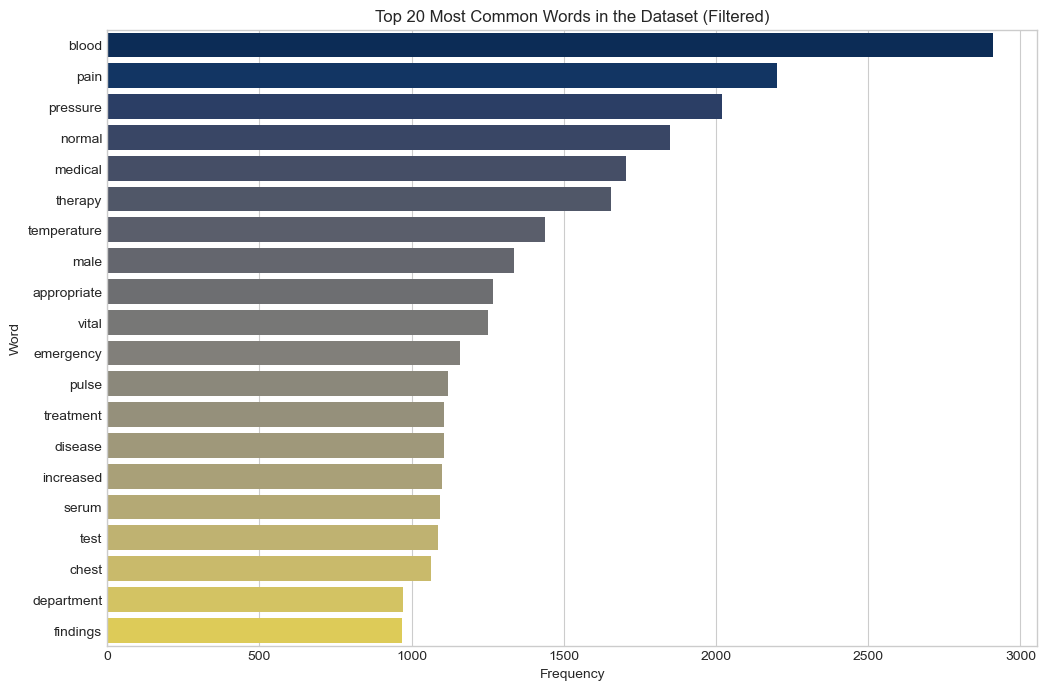

In [34]:
# --- Vocabulary and Word Frequency Analysis ---
def get_all_text(row):
    question_text = row['question']
    options_text = ' '.join(row['options'].values())
    return question_text + ' ' + options_text

report_title = "Vocabulary and Word Frequency Analysis"
corpus = ' '.join(df_all.apply(get_all_text, axis=1)).lower()
words = word_tokenize(corpus)
word_counts = Counter(words)
vocab_stats = (
    f"Total number of words (tokens): {len(words)}\n"
    f"Vocabulary size (unique words): {len(word_counts)}"
)
write_to_report(vocab_stats, title=report_title)

# Ensure you have the NLTK stopwords dataset downloaded
try:
    stop_words = set(nltk.corpus.stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(nltk.corpus.stopwords.words('english'))

punctuation = set(string.punctuation)

# NEW: A more comprehensive list of uninformative words
custom_uninformative_words = {
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', # Answer choices
    'answer', 'choices', 'following', 'of', 'in', 'the', 'is', 'a', 'to', 'and', 'with', # General uninformative words
    'which', 'what', 'most', 'likely', 'patient', 'from', 'her', 'his', 'for', 'that', 'on',
    'are', 'as', 'has', 'had', 'or', 'an', 'be', 'by', 'at', 'this', 'have', 'been', 'was',
    'he', 'she', 'it', 'report', 'reports', 'show', 'shows', 'shown', 'examination', 'physical',
    'history', 'mg', 'mm', 'hg', 'bpm', 'f', 'min', 'h', 'degrees', 'mmhg', # Common units/measurements that might obscure medical concepts
    'right', 'left', 'reveals', 'reveal', 'figure', 'presents', 'present', '--', 'signs', 'rate', 'due'
}

# The logic now checks against three sets: standard stopwords, custom words, and punctuation.
filtered_words = [
    word for word in words 
    if word.isalpha() and # Keep only alphabetic words
       word not in stop_words and 
       word not in punctuation and 
       word not in custom_uninformative_words
]

filtered_word_counts = Counter(filtered_words)

# The rest of your code remains the same, just using the new filtered data
word_counts = filtered_word_counts # Overwrite the old counts with the new filtered ones
vocab_stats = (
    f"Total number of words (tokens) after filtering: {len(filtered_words)}\n"
    f"Vocabulary size (unique words) after filtering: {len(word_counts)}"
)
write_to_report(vocab_stats, title="Vocabulary and Word Frequency Analysis (Filtered)")

most_common_words = word_counts.most_common(20)
mcw_df = pd.DataFrame(most_common_words, columns=['word', 'count'])
write_to_report(mcw_df, title="20 Most Common Words (Filtered)")

# Plot and show the frequency of the most common words
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='word', data=mcw_df, hue='word', palette='cividis', legend=False)
plt.title('Top 20 Most Common Words in the Dataset (Filtered)')
plt.xlabel('Frequency')
plt.ylabel('Word')
image_path = os.path.join(OUTPUT_DIR, "top_20_words.png")
plt.savefig(image_path)
write_to_report(f"Image saved to: {image_path}", title="Plot: Top 20 Most Common Words")
plt.show()

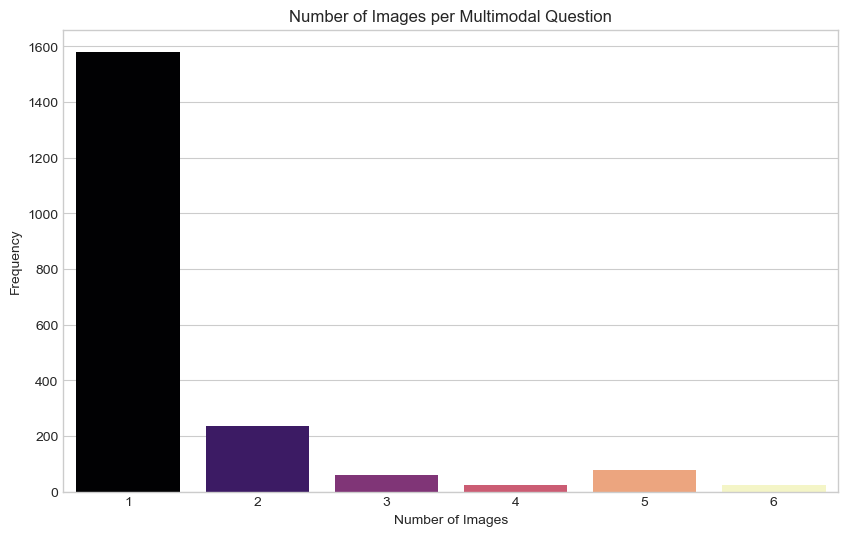

In [35]:
# Section for Multimodality
df_mm['num_images'] = df_mm['images'].apply(lambda x: len(x) if isinstance(x, list) else 0)
write_to_report(df_mm['num_images'].describe(), title="Statistics for Number of Images per Question (MM set)")
# Also write the raw counts table to the report
write_to_report(df_mm['num_images'].value_counts().to_string(), title="Data Table: Number of Images per Question")

# Plotting the distribution of the number of images per question
plt.figure(figsize=(10, 6))
sns.countplot(x='num_images', data=df_mm, hue='num_images', palette='magma', legend=False)
plt.title('Number of Images per Multimodal Question')
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
image_path = os.path.join(OUTPUT_DIR, "mm_image_count_distribution.png")
plt.savefig(image_path)
write_to_report(f"Image saved to: {image_path}", title="Plot: Number of Images per Question")
plt.show()


--- Performing Deeper Multimodal Analysis ---


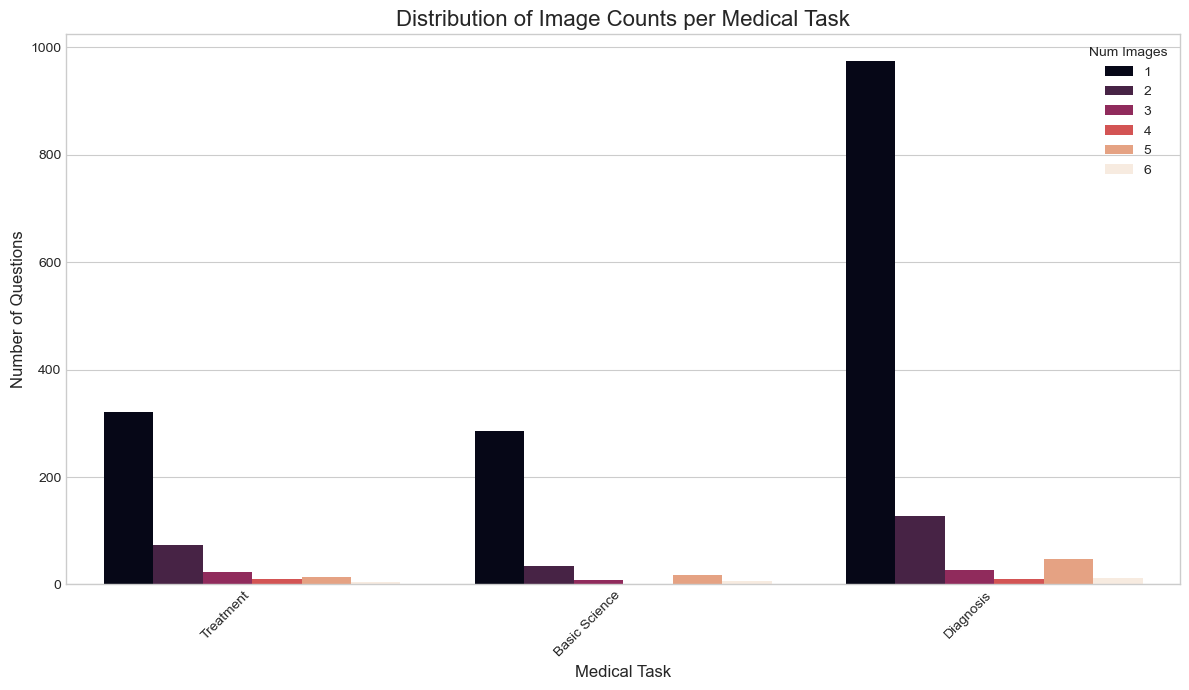

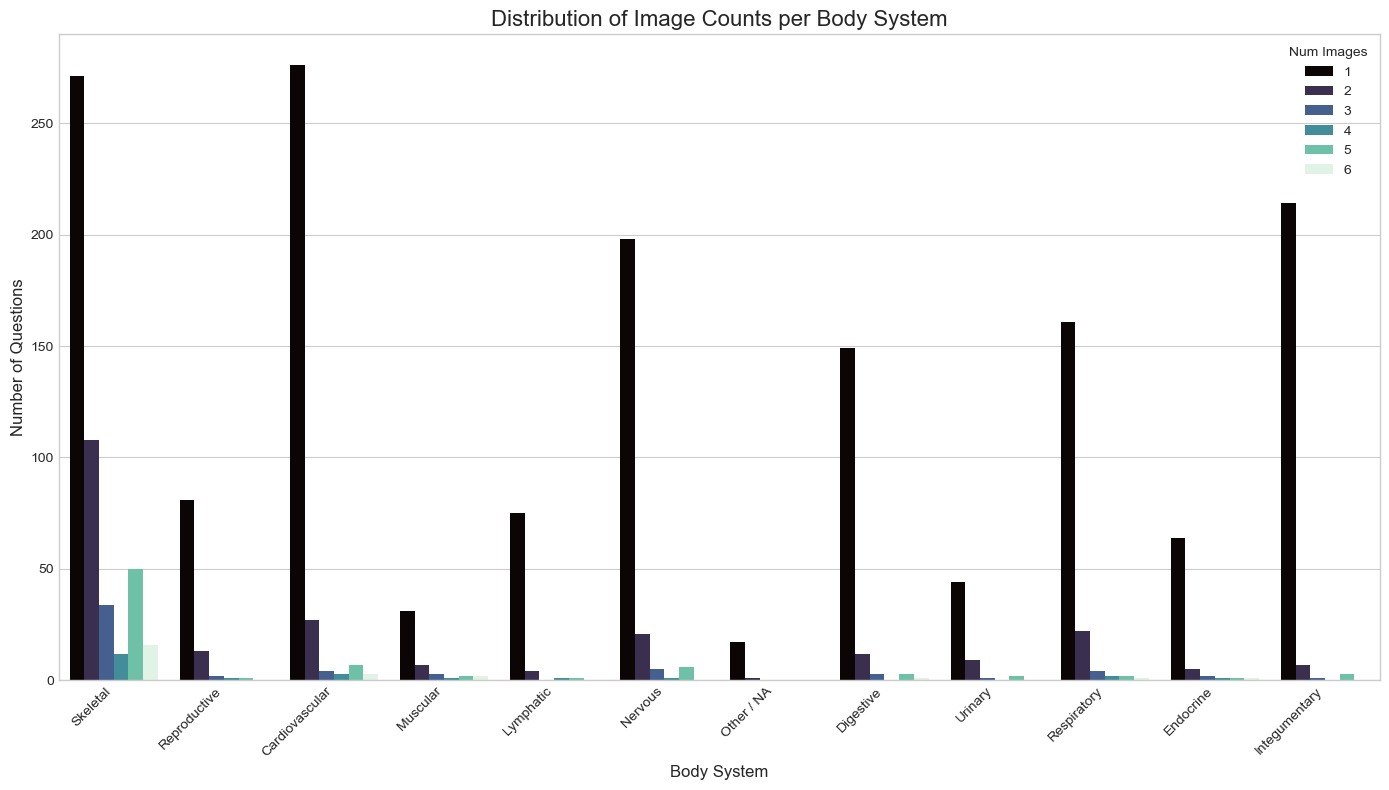


Image File Type Distribution:
jpeg    2683
png      161
JPG        8
Name: count, dtype: int64


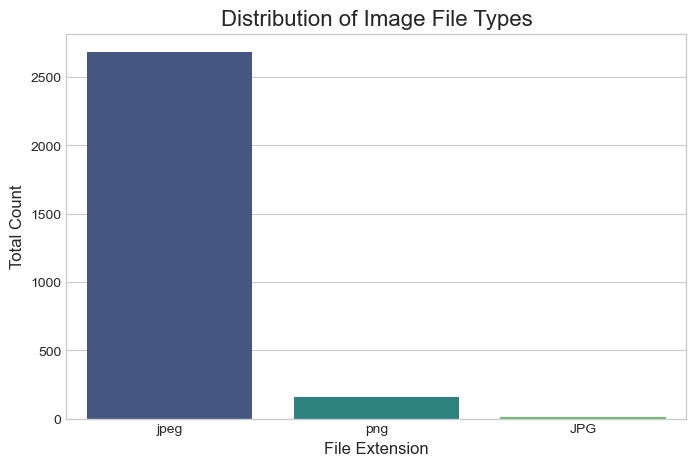


--- Deeper Multimodal Analysis Complete ---


In [36]:
print("\n--- Performing Deeper Multimodal Analysis ---")

# Ensure the 'num_images' column exists from the initial analysis
if 'num_images' not in df_mm.columns:
    df_mm['num_images'] = df_mm['images'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    
crosstab_task_vs_images = pd.crosstab(df_mm['medical_task'], df_mm['num_images'])
write_to_report(crosstab_task_vs_images.to_string(), title="Data Table: Image Counts per Medical Task")

# --- Correlation with Other Features (Number of Images vs. Medical Task) ---

plt.figure(figsize=(12, 7))
sns.countplot(x='medical_task', hue='num_images', data=df_mm, palette='rocket')
plt.title('Distribution of Image Counts per Medical Task', fontsize=16)
plt.xlabel('Medical Task', fontsize=12)
plt.ylabel('Number of Questions', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Num Images')
plt.tight_layout()
image_path_1 = os.path.join(OUTPUT_DIR, "image_count_vs_task.png")
plt.savefig(image_path_1)
write_to_report(f"Image saved to: {image_path_1}", title="Plot: Image Counts per Medical Task")
plt.show()


# --- Correlation with Other Features (Number of Images vs. Body System) ---
crosstab_system_vs_images = pd.crosstab(df_mm['body_system'], df_mm['num_images'])
write_to_report(crosstab_system_vs_images.to_string(), title="Data Table: Image Counts per Body System")

plt.figure(figsize=(14, 8))
sns.countplot(x='body_system', hue='num_images', data=df_mm, palette='mako')
plt.title('Distribution of Image Counts per Body System', fontsize=16)
plt.xlabel('Body System', fontsize=12)
plt.ylabel('Number of Questions', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Num Images')
plt.tight_layout()
image_path_2 = os.path.join(OUTPUT_DIR, "image_count_vs_system.png")
plt.savefig(image_path_2)
write_to_report(f"Image saved to: {image_path_2}", title="Plot: Image Counts per Body System")
plt.show()


# --- Image Type Analysis (File Extension) ---

# This function extracts the file extension from a list of image filenames
def get_extensions(image_list):
    if not isinstance(image_list, list):
        return []
    return [filename.split('.')[-1] for filename in image_list]

# Get a flat list of all extensions
all_extensions = [ext for sublist in df_mm['images'].apply(get_extensions) for ext in sublist]

# Count the occurrences of each extension
extension_counts = pd.Series(all_extensions).value_counts()

print("\nImage File Type Distribution:")
print(extension_counts)

report_title_images = "Image File Type Distribution"
write_to_report(extension_counts, title=report_title_images)

# Visualize the file extension counts
plt.figure(figsize=(8, 5))
sns.barplot(x=extension_counts.index, y=extension_counts.values, hue=extension_counts.index, palette='viridis')
plt.title('Distribution of Image File Types', fontsize=16)
plt.xlabel('File Extension', fontsize=12)
plt.ylabel('Total Count', fontsize=12)
image_path_3 = os.path.join(OUTPUT_DIR, "image_extension_distribution.png")
plt.savefig(image_path_3)
write_to_report(f"Image saved to: {image_path_3}", title="Plot: Image File Type Distribution")
plt.show()


print("\n--- Deeper Multimodal Analysis Complete ---")

--- Generating Combined Feature Analysis Heatmaps ---


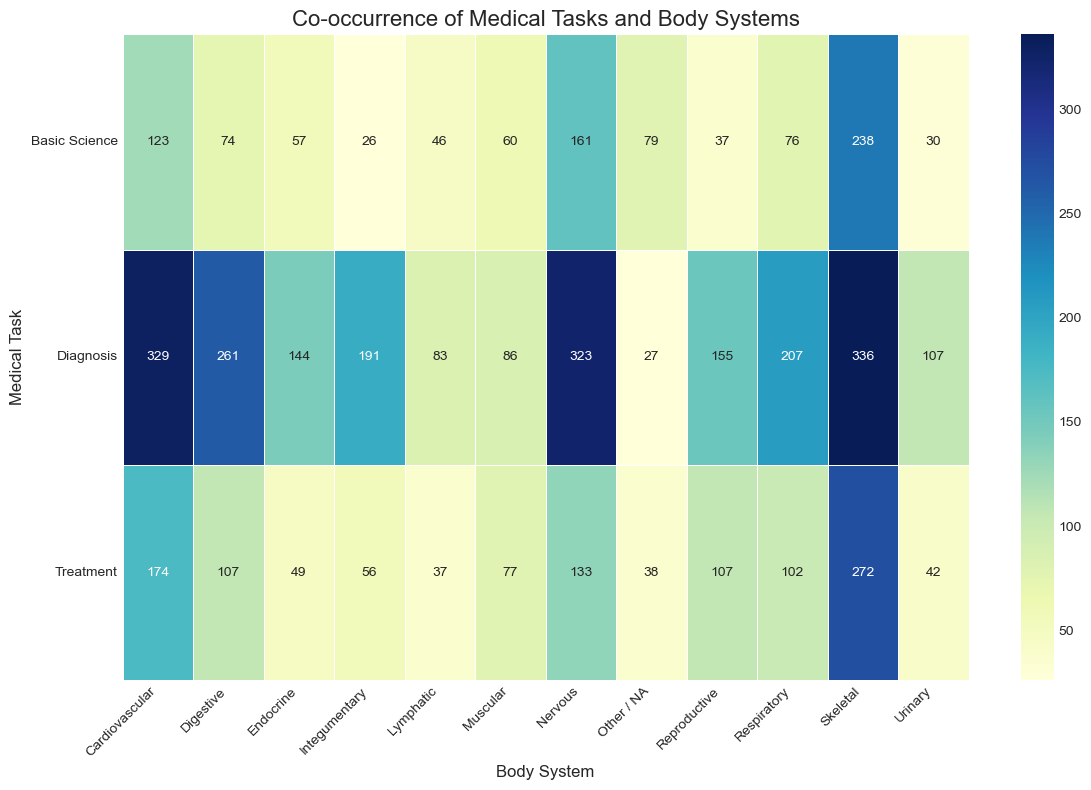

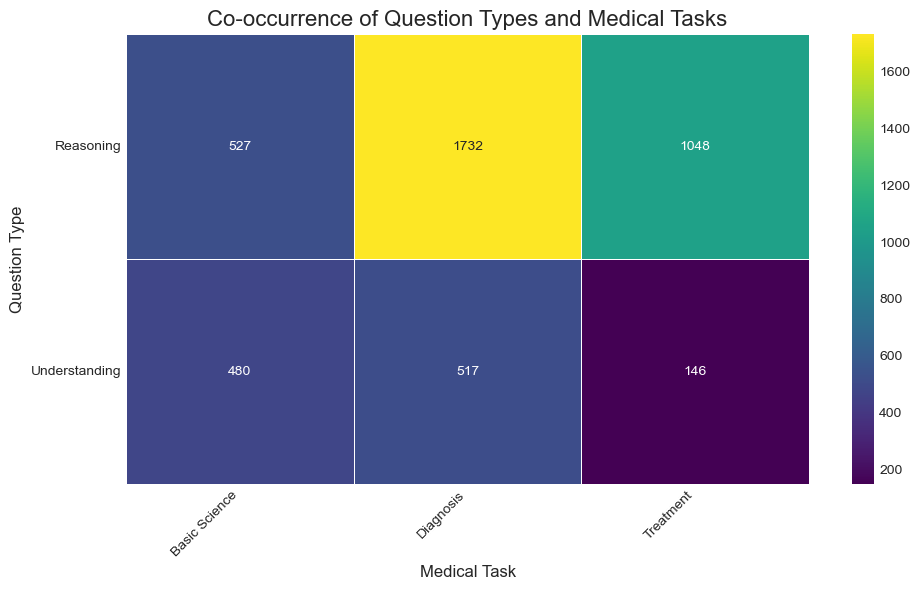

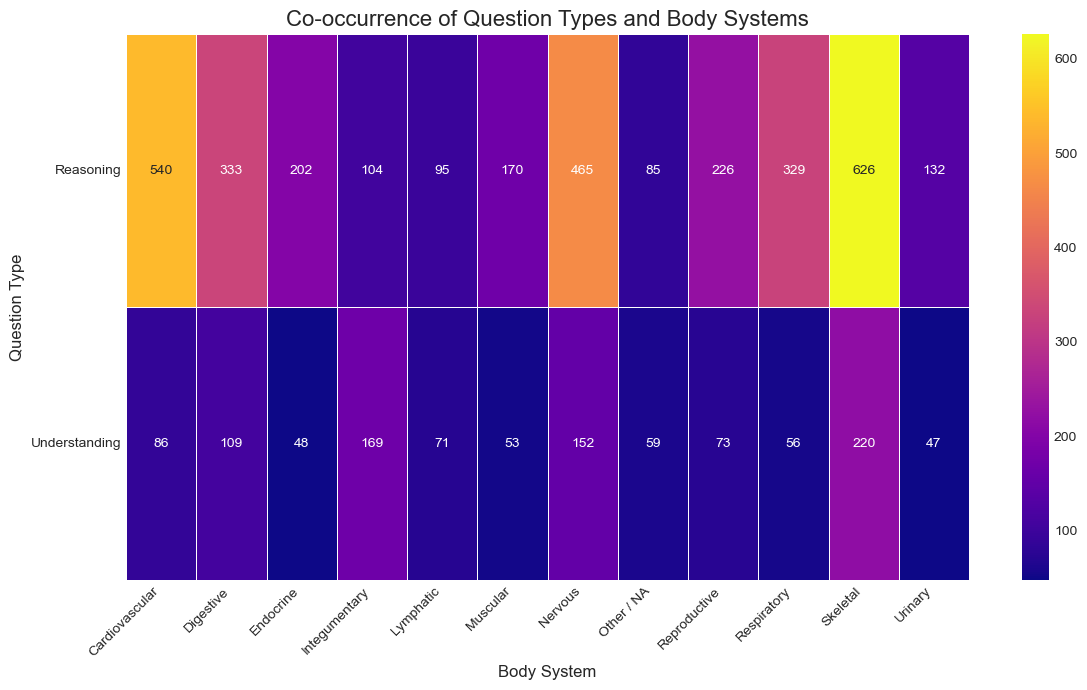

--- Heatmap generation complete ---


In [37]:
print("--- Generating Combined Feature Analysis Heatmaps ---")

# --- Heatmap 1: Medical Task vs. Body System ---
report_title_1 = "Combined Analysis: Medical Task vs. Body System"
crosstab_task_vs_system = pd.crosstab(df_all['medical_task'], df_all['body_system'])

# Optional: Write the raw data table to your report file
write_to_report(crosstab_task_vs_system, title=report_title_1)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(crosstab_task_vs_system, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5)
plt.title('Co-occurrence of Medical Tasks and Body Systems', fontsize=16)
plt.xlabel('Body System', fontsize=12)
plt.ylabel('Medical Task', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to make room for labels
image_path_1 = os.path.join(OUTPUT_DIR, "heatmap_task_vs_system.png")
plt.savefig(image_path_1)
write_to_report(f"Image saved to: {image_path_1}", title="Plot: Heatmap of Task vs. System")
plt.show()

# --- Heatmap 2: Question Type vs. Medical Task ---
report_title_2 = "Combined Analysis: Question Type vs. Medical Task"
crosstab_type_vs_task = pd.crosstab(df_all['question_type'], df_all['medical_task'])

# Optional: Write the raw data table to your report file
write_to_report(crosstab_type_vs_task, title=report_title_2)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab_type_vs_task, annot=True, fmt='d', cmap='viridis', linewidths=.5)
plt.title('Co-occurrence of Question Types and Medical Tasks', fontsize=16)
plt.xlabel('Medical Task', fontsize=12)
plt.ylabel('Question Type', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
image_path_2 = os.path.join(OUTPUT_DIR, "heatmap_type_vs_task.png")
plt.savefig(image_path_2)
write_to_report(f"Image saved to: {image_path_2}", title="Plot: Heatmap of Type vs. Task")
plt.show()


# --- Heatmap 3: Question Type vs. Body System ---
report_title_3 = "Combined Analysis: Question Type vs. Body System"
crosstab_type_vs_system = pd.crosstab(df_all['question_type'], df_all['body_system'])

# Optional: Write the raw data table to your report file
write_to_report(crosstab_type_vs_system, title=report_title_3)

# Create the heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(crosstab_type_vs_system, annot=True, fmt='d', cmap='plasma', linewidths=.5)
plt.title('Co-occurrence of Question Types and Body Systems', fontsize=16)
plt.xlabel('Body System', fontsize=12)
plt.ylabel('Question Type', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
image_path_3 = os.path.join(OUTPUT_DIR, "heatmap_type_vs_system.png")
plt.savefig(image_path_3)
write_to_report(f"Image saved to: {image_path_3}", title="Plot: Heatmap of Type vs. System")
plt.show()

print("--- Heatmap generation complete ---")